# 5.7 Covid

Nuestro objetivo es crear un modelo para determinar el numero de casos de Covid que puden haber la proxima semana.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb

In [2]:
# Unlimit pandas display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## ETL

In [3]:
# Cargamos los datos

original = pd.read_csv('data/5.7.covid data.csv', sep = ',', header = 0)

In [4]:
# Cambiamos el tipo de la columna fecha de string a datetime
original['date']= pd.to_datetime(original['date'])

# Ponemos la fecha como inidice
original = original.set_index('date')

In [5]:
original.tail()

cases  deaths
date                        
2021-04-02  30631753  553554
2021-04-03  30695580  554302
2021-04-04  30732273  554579
2021-04-05  30808897  555109
2021-04-06  30870922  556016

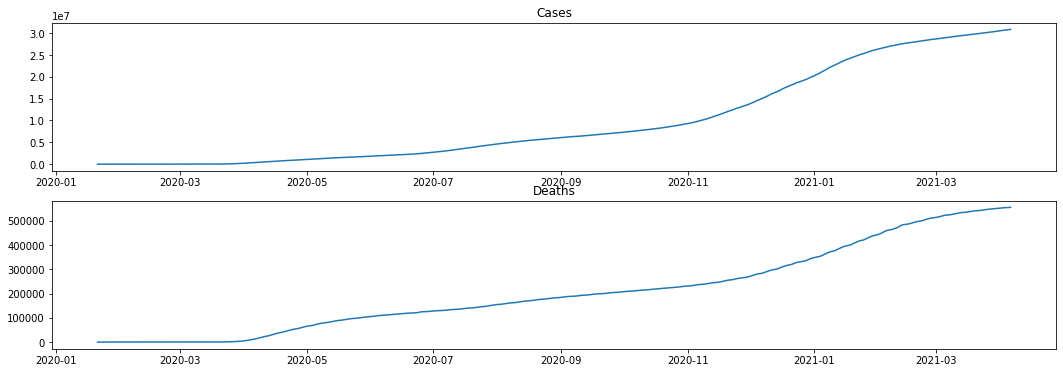

In [6]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(original['cases'])
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(original['deaths'])
axis[1].set_title("Deaths")

plt.show()

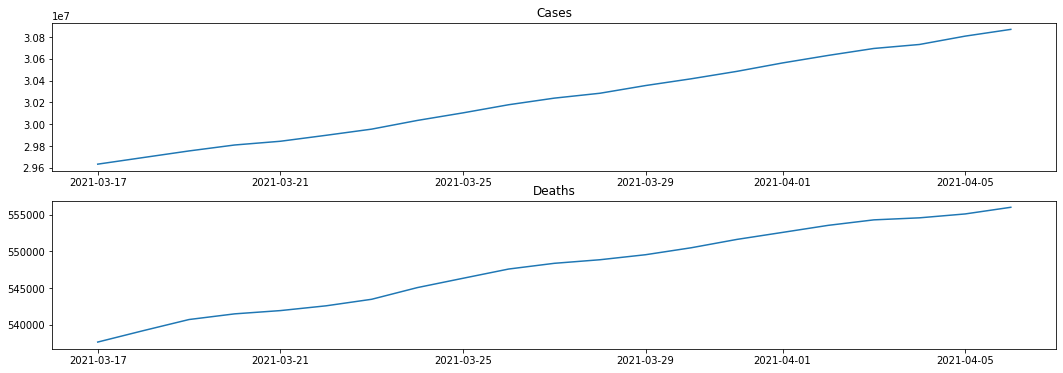

In [7]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(original['cases'].tail(21))
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(original['deaths'].tail(21))
axis[1].set_title("Deaths")

plt.show()

No se muestra una estacionalidad aparente. Si nos fijamos en las ultimas 3 semanas de datos la grafica de casos parece casi lineal.

Como los datos son sobre el total acumulado de casos vamos a pasarlos a casos diarios a ver si vemos algo mas.

In [8]:
# Create a copy of the original data frame
df = original.copy()

df['cases'] = pd.Series(df['cases']).diff()
df['deaths'] = pd.Series(df['deaths']).diff()

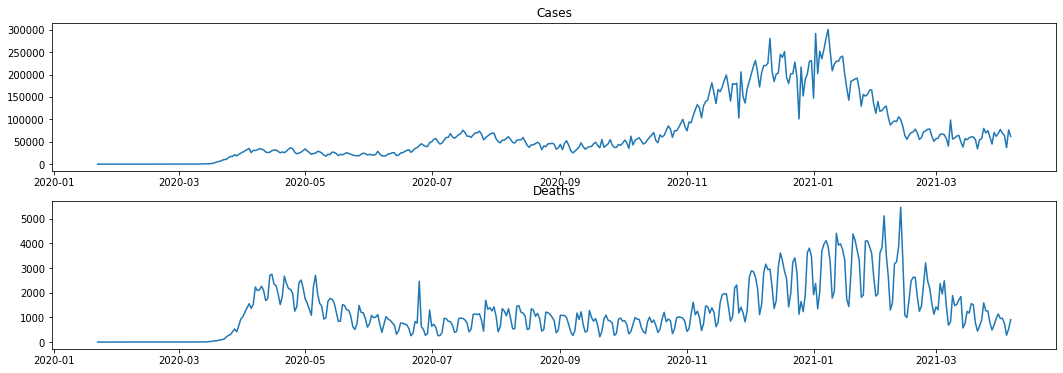

In [9]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(df['cases'])
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(df['deaths'])
axis[1].set_title("Deaths")

plt.show()

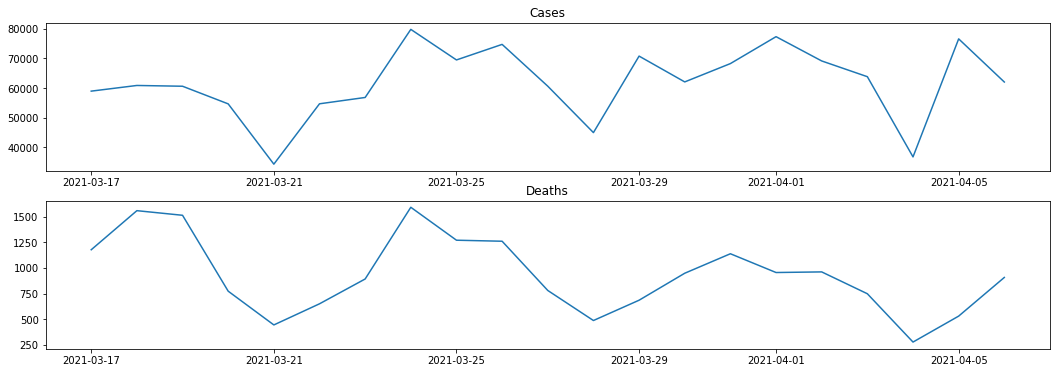

In [10]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(df['cases'].tail(21))
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(df['deaths'].tail(21))
axis[1].set_title("Deaths")

plt.show()

Con esta transformacion ya vemos cierta estacionalidad, pero sigue habiendo tendencia.

Vamos a descartar el uso de ARIMA ya que necesitariamos un tratamiento muy grande de los datos y aun asi no nos garantiza que lleguemos a una serie suficientemente buena.

La estacionalidad que se muestra en las 3 ultimas semanas nos indica que hay menos casos los domingos, seguramente porque la recogida de datos es menor al ser festivo.

In [11]:
# Separmos los datos de testeo
target_test = pd.Series(df['2021-03-01':]['cases'])

## Modelo Naive

In [12]:
# datos a validar con predicción de método naive
# la predicción será el valor anterior
naive_forecast = pd.Series(df['2021-02-28':]['cases']).shift(1)[1:]

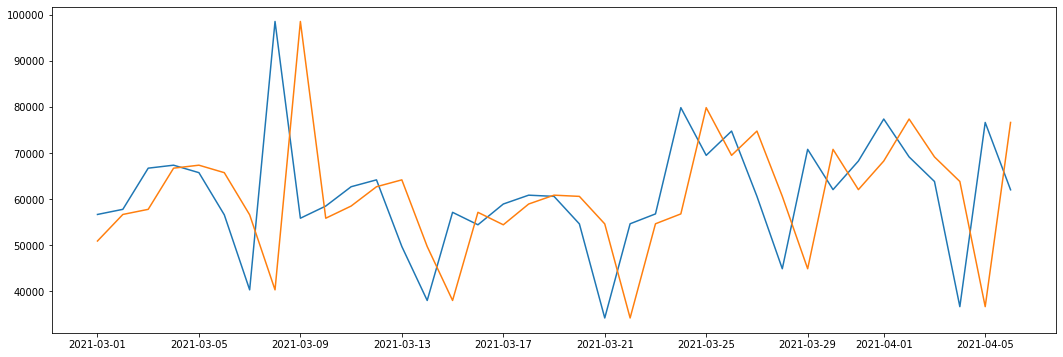

In [13]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(naive_forecast)

In [14]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, naive_forecast))
print('Error mae: ', mean_absolute_error(target_test, naive_forecast))

Error mse:  322464372.7837838
Error mae:  12697.216216216217


Los errores son muy grandes en magnitud pero esto es debido a que los datos tambien lo son.

Vamos a usar este metodo como referencia para los siguientes, asi sabremos si podemos mejorar la intuición más basica.

## Modelo Random Forest Regressor

In [15]:
# Funcion para crear el data set para entrenar
# Necesitamos que para cada dia que vamos a predecir tener los dias de la ventana de tiempo que tocan 
# movidos los horizontes que corresponda
def extended_data(data_frame, window_size = 7, step_size = 1, horizon = 1):
    for i in range(1, window_size + 1):
        data_frame['cases-' + str(i)] = df['cases'].shift(i + horizon - 1)
        data_frame['deaths-' + str(i)] = df['deaths'].shift(i + horizon - 1)
    return data_frame

In [16]:
data = extended_data(df.copy(), window_size = 14, horizon = 1)
data.tail(5)

cases  deaths  cases-1  deaths-1  cases-2  deaths-2  cases-3  \
date                                                                         
2021-04-02  69152.0   961.0  77369.0     955.0  68262.0    1138.0  62061.0   
2021-04-03  63827.0   748.0  69152.0     961.0  77369.0     955.0  68262.0   
2021-04-04  36693.0   277.0  63827.0     748.0  69152.0     961.0  77369.0   
2021-04-05  76624.0   530.0  36693.0     277.0  63827.0     748.0  69152.0   
2021-04-06  62025.0   907.0  76624.0     530.0  36693.0     277.0  63827.0   

            deaths-3  cases-4  deaths-4  cases-5  deaths-5  cases-6  deaths-6  \
date                                                                            
2021-04-02     948.0  70794.0     685.0  44910.0     487.0  60614.0     780.0   
2021-04-03    1138.0  62061.0     948.0  70794.0     685.0  44910.0     487.0   
2021-04-04     955.0  68262.0    1138.0  62061.0     948.0  70794.0     685.0   
2021-04-05     961.0  77369.0     955.0  68262.0    1138.0  62061.0     948.0   
2021-04-06     748.0  69152.0     961.0  77369.0     955.0  68262.0    1138.0   

            cases-7  deaths-7  cases-8  deaths-8  cases-9  deaths-9  cases-10  \
date                                                                            
2021-04-02  74756.0    1260.0  69494.0    1270.0  79835.0    1591.0   56799.0   
2021-04-03  60614.0     780.0  74756.0    1260.0  69494.0    1270.0   79835.0   
2021-04-04  44910.0     487.0  60614.0     780.0  74756.0    1260.0   69494.0   
2021-04-05  70794.0     685.0  44910.0     487.0  60614.0     780.0   74756.0   
2021-04-06  62061.0     948.0  70794.0     685.0  44910.0     487.0   60614.0   

            deaths-10  cases-11  deaths-11  cases-12  deaths-12  cases-13  \
date                                                                        
2021-04-02      892.0   54658.0      650.0   34237.0      444.0   54631.0   
2021-04-03     1591.0   56799.0      892.0   54658.0      650.0   34237.0   
2021-04-04     1270.0   79835.0     1591.0   56799.0      892.0   54658.0   
2021-04-05     1260.0   69494.0     1270.0   79835.0     1591.0   56799.0   
2021-04-06      780.0   74756.0     1260.0   69494.0     1270.0   79835.0   

            deaths-13  cases-14  deaths-14  
date                                        
2021-04-02      773.0   60598.0     1513.0  
2021-04-03      444.0   54631.0      773.0  
2021-04-04      650.0   34237.0      444.0  
2021-04-05      892.0   54658.0      650.0  
2021-04-06     1591.0   56799.0      892.0

<AxesSubplot:>

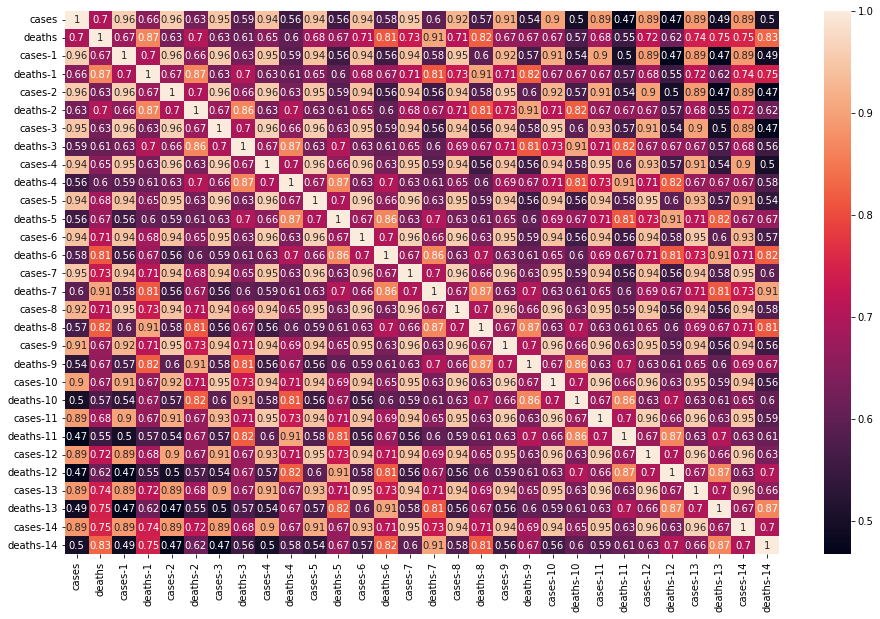

In [17]:
# Pintamos la matrix de correlacion

plt.figure(figsize = (16, 10))
sns.heatmap(data.corr(), annot = True)

La correlacion entre los casos y las muertes no es muy alto, pero la autocorrelacion es alta sobretodo con los casos. Asi que podemos dejar los datos de muertes para entrenar si problema.

In [18]:
# Generamos el train data sin los registros con nulos ni los registros de test
X_train_1 = data[15:-len(target_test)]
y_train_1 = X_train_1[['cases', 'deaths']]
X_train_1 = X_train_1.drop(columns = ['cases', 'deaths'])

# Generamos el test data
X_test_1 = data[-len(target_test):]
y_test_1 = X_test_1[['cases', 'deaths']]
X_test_1 = X_test_1.drop(columns = ['cases', 'deaths'])

In [19]:
# Creamos y entrenamos el modelo
rfr = RandomForestRegressor(random_state=0).fit(X_train_1, y_train_1)

In [20]:
# Hacemos una prediccion con los datos de test, usamos los datos reales y los los predichos para cada dia de testeo 
rfr_forecast = pd.DataFrame(rfr.predict(X_test_1), columns=['cases', 'deaths'])

# Añadimos la fecha a las predicciones y la ponemos como indice
rfr_forecast['date'] = pd.date_range(start='2021-03-01', end='2021-04-06')
rfr_forecast = rfr_forecast.set_index('date')

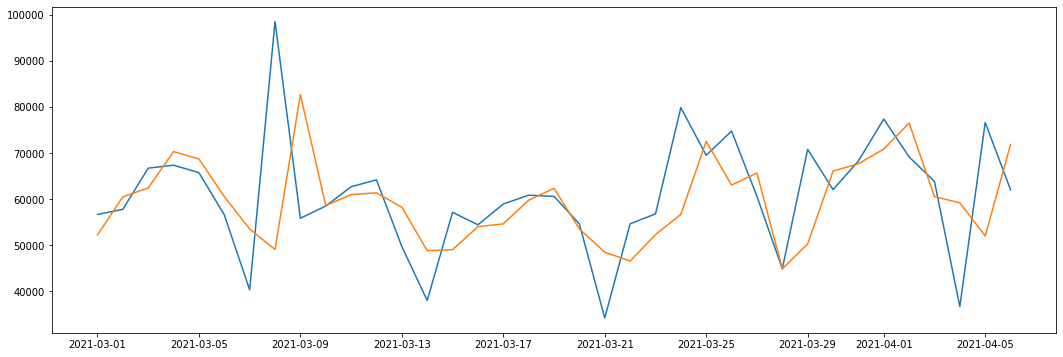

In [21]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(rfr_forecast['cases'])

In [22]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, rfr_forecast['cases']))
print('Error mae: ', mean_absolute_error(target_test, rfr_forecast['cases']))

Error mse:  174470207.85157022
Error mae:  8661.164594594597


Ahora hacemos las predicciones usando los datos que predice el modelo para los dias que dependan de otros dias que ya hemos predicho.

In [23]:
# Funcion para generar una nueva linea en el dataframe usando las predicciones
def new_line(data, new, n):
    data = np.array(data)
    
    # Movemos los datos para eliminar las columnas mas antiguas
    for i in range(len(data[0]) - 1, n - 1, -1):
        data[0][i] = data[0][i - n]
    
    # Anadimos las predicciones a los datos
    for j in range(n):
        if n > 1:
            data[0][j] = new[0][j]
        else:
            data[0][j] = new[0]
    
    return data

# Funcion para hacer las predicciones dinamicas en un intervalo de fechas
def make_predictions(model, initial_data, curr_day, last_day, pred_col):
    X_pred = initial_data
    cols = X_pred.columns
    forecast = pd.DataFrame()
    
    # Para cada dia a predecir
    while curr_day <= last_day:
        # Hacemos la prediccion con los datos que toquen
        pred = model.predict(X_pred[-1:])
        
        # Nos guardamos la prediccion
        forecast = forecast.append(pd.DataFrame(pred, columns = pred_col, index = [curr_day]))
        
        # Sumamos un dia
        curr_day = curr_day + pd.DateOffset(1)
        
        # Anadimos los datos de la prediccion junto con los pasados para hacer las siguentes predicciones
        X_pred = X_pred.append(pd.DataFrame(new_line(X_pred[-1:], pred, len(pred_col)), columns = cols, index = [curr_day]))
    
    return forecast

In [24]:
rfr_dynamic_forecast = make_predictions(rfr, X_test_1[:1], pd.to_datetime('2021-03-01'), pd.to_datetime('2021-04-06'), ['cases', 'deaths'])

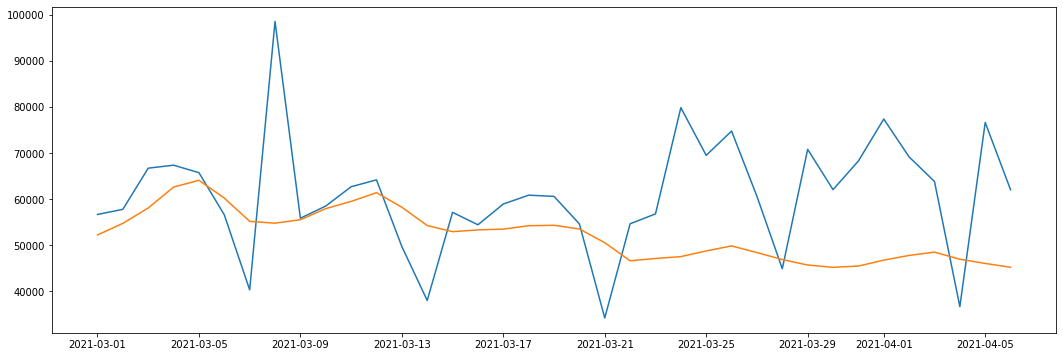

In [25]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(rfr_dynamic_forecast['cases'])

In [26]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, rfr_dynamic_forecast['cases']))
print('Error mae: ', mean_absolute_error(target_test, rfr_dynamic_forecast['cases']))

Error mse:  265158048.11260003
Error mae:  12344.946486486488


## Modelo XGBoost

Para usar XGBoost vamos a usar solo los datos de los casos ya que no podemos hacer regressiones multivariables.

In [27]:
# Funcion para crear el data set para entrenar
# Necesitamos que para cada dia que vamos a predecir tener los dias de la ventana de tiempo que tocan 
# movidos los horizontes que corresponda
def extended_cases(data_frame, window_size = 7, step_size = 1, horizon = 1):
    data_frame = data_frame.drop(columns = ['deaths'])
    for i in range(1, window_size + 1):
        data_frame['cases-' + str(i)] = df['cases'].shift(i + horizon - 1)
    return data_frame

In [28]:
case_data = extended_cases(df.copy(), window_size = 14, horizon = 1)
case_data.head(10)

cases  cases-1  cases-2  cases-3  cases-4  cases-5  cases-6  \
date                                                                      
2020-01-21    NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2020-01-22    0.0      NaN      NaN      NaN      NaN      NaN      NaN   
2020-01-23    0.0      0.0      NaN      NaN      NaN      NaN      NaN   
2020-01-24    1.0      0.0      0.0      NaN      NaN      NaN      NaN   
2020-01-25    1.0      1.0      0.0      0.0      NaN      NaN      NaN   
2020-01-26    2.0      1.0      1.0      0.0      0.0      NaN      NaN   
2020-01-27    0.0      2.0      1.0      1.0      0.0      0.0      NaN   
2020-01-28    0.0      0.0      2.0      1.0      1.0      0.0      0.0   
2020-01-29    0.0      0.0      0.0      2.0      1.0      1.0      0.0   
2020-01-30    1.0      0.0      0.0      0.0      2.0      1.0      1.0   

            cases-7  cases-8  cases-9  cases-10  cases-11  cases-12  cases-13  \
date                                                                            
2020-01-21      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-22      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-23      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-24      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-25      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-26      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-27      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-28      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-29      0.0      NaN      NaN       NaN       NaN       NaN       NaN   
2020-01-30      0.0      0.0      NaN       NaN       NaN       NaN       NaN   

            cases-14  
date                  
2020-01-21       NaN  
2020-01-22       NaN  
2020-01-23       NaN  
2020-01-24       NaN  
2020-01-25       NaN  
2020-01-26       NaN  
2020-01-27       NaN  
2020-01-28       NaN  
2020-01-29       NaN  
2020-01-30       NaN

In [29]:
# Generamos el train data sin los registros con nulos ni los registros de test
X_train_2 = case_data[15:-len(target_test)]
y_train_2 = X_train_2['cases']
X_train_2 = X_train_2.drop(columns = ['cases'])

# Generamos el test data
X_test_2 = case_data[-len(target_test):]
y_test_2 = X_test_2['cases']
X_test_2 = X_test_2.drop(columns = ['cases'])

In [30]:
# Creamos y entrenamos el modelo
gbr = GradientBoostingRegressor(n_estimators=40, random_state=1, verbose=1).fit(X_train_2, y_train_2)

      Iter       Train Loss   Remaining Time 
         1  4034680148.0801            0.05s
         2  3319196028.0908            0.05s
         3  2734871066.9220            0.05s
         4  2261700683.5411            0.04s
         5  1873881702.7333            0.04s
         6  1557284974.1429            0.04s
         7  1292177403.9425            0.04s
         8  1077020301.2378            0.04s
         9   902780299.5572            0.04s
        10   759240172.4058            0.04s
        20   187649625.3696            0.03s
        30    91413263.2860            0.01s
        40    59185767.6119            0.00s


In [31]:
# Hacemos una prediccion con los datos de test, usamos los datos reales y los los predichos para cada dia de testeo 
gbr_forecast = pd.DataFrame(gbr.predict(X_test_2), columns = ['cases'])

# Añadimos la fecha a las predicciones y la ponemos como indice
gbr_forecast['date'] = pd.date_range(start='2021-03-01', end='2021-04-06')
gbr_forecast = gbr_forecast.set_index('date')

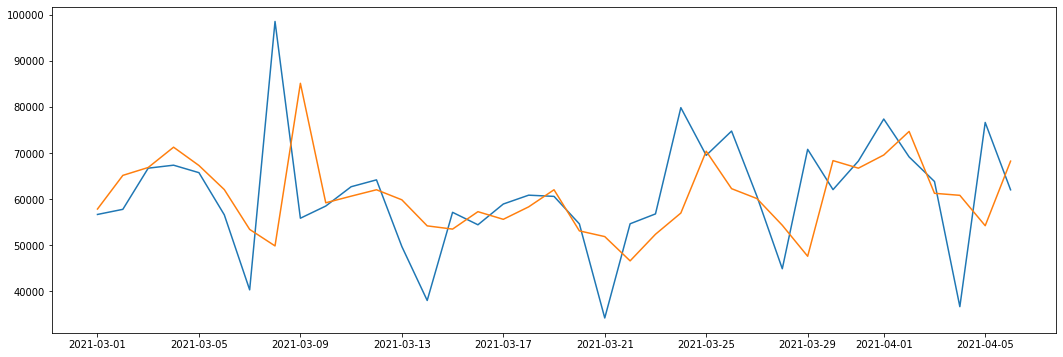

In [32]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(gbr_forecast)

In [33]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, gbr_forecast))
print('Error mae: ', mean_absolute_error(target_test, gbr_forecast))

Error mse:  185877239.5187644
Error mae:  8999.581013893454


In [34]:
gbr_dynamic_forecast = make_predictions(gbr, X_test_2[:1], pd.to_datetime('2021-03-01'), pd.to_datetime('2021-04-06'), ['cases'])

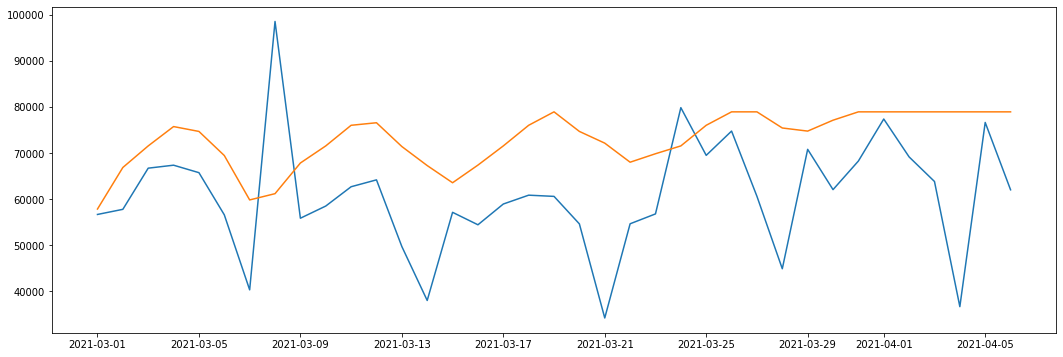

In [35]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(gbr_dynamic_forecast['cases'])

In [36]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, gbr_dynamic_forecast['cases']))
print('Error mae: ', mean_absolute_error(target_test, gbr_dynamic_forecast['cases']))

Error mse:  309082873.4947235
Error mae:  14562.23328950444


Vemos que con el XGBoost sin usar los datos de las muertes los resultados peores tanto usando lso resultados reales como haciendo las predicciones con los valores predichos.

## Modelo Random Forest Regressor con Horizons

Vamos a probar a hacer las predicciones con horizontes de 1 a 7 dias, asi para predecir los casos de una semana solo necesitaremos los casos del window que querramos hacia atras.

Como parece que el modelo que tambien tiene en cuenta las muertes es más preciso vamos a usarlo tambien en este caso.

In [37]:
# Funcion para crear una lista de data frames con un mismo window size y horizontes seguidos
def create_data_horizons(df, win_size, h):
    horizons = []
    for i in range(1, h + 1):
        horizons.append(extended_data(df.copy(), window_size = win_size, horizon = i))
    
    return horizons

# Funcion para crear los datos de entrenamiento para cada horizonte
def create_training_data(df, win_size, h, target_test):
    horizons = create_data_horizons(df, win_size, h)
    
    X = []
    y = []
    
    for i in range(len(horizons)):
        data = horizons[i][win_size + i + 1:-len(target_test)]
        X.append(data.drop(columns = ['cases', 'deaths']))
        y.append(data[['cases', 'deaths']])
    
    return X, y

# Funcion para crear los datos de testeo para cada horizonte
def create_test_data(df, win_size, h, target_test):
    horizons = create_data_horizons(df, win_size, h)
    
    X = []
    
    for i in range(len(horizons)):
        data = horizons[i][-len(target_test):]
        X.append(data.drop(columns = ['cases', 'deaths']))
    
    return X

In [38]:
X_train_horizons, y_train_horizons = create_training_data(df, 14, 7, target_test)

In [39]:
# Creamos una lista de modelos para cada horizonte y los entrenamos
rfr_hor = []
for i in range(len(X_train_horizons)):
    # Creamos y entrenamos el modelo
    rfr_hor.append(RandomForestRegressor(random_state=0).fit(X_train_horizons[i], y_train_horizons[i]))

Este modelo nos genera un prediccion de los 7 dias siguientes para cada dia que le demos.

Para comparar los resultados de este con los modelos anteriores podemos hacer predicciones dinamicas de longitud semanal para cada modelo y comparar los resultados.

In [40]:
# Funcion para crear predicciones usando el modelo de horizontes consequtivos
def make_horizon_predictions(X, models, curr_date, pred_col):
    forecast = pd.DataFrame()
    for i in range(len(models)):
        pred = models[i].predict(X[i])
        forecast = forecast.append(pd.DataFrame(pred, columns = pred_col, index = [curr_date]))
        curr_date = curr_date + pd.DateOffset(1)
    
    return forecast

In [41]:
X_test_horizons = create_test_data(df, 14, 7, target_test)

Vamos a ver como funciona para predecir la primera semana de test.

In [42]:
# Creamos los datos para hace la prediccion para un semana entera
X = []
for i in range(7):
    X.append(X_test_horizons[i][:1])

In [43]:
pred = make_horizon_predictions(X, models = rfr_hor, curr_date = pd.to_datetime('2021-03-01'), pred_col = ['cases', 'deaths'])

In [44]:
rfr_dynamic_forecast = make_predictions(rfr, X_test_1[0:1], pd.to_datetime('2021-03-01'), pd.to_datetime('2021-03-01') + pd.DateOffset(6), ['cases', 'deaths'])

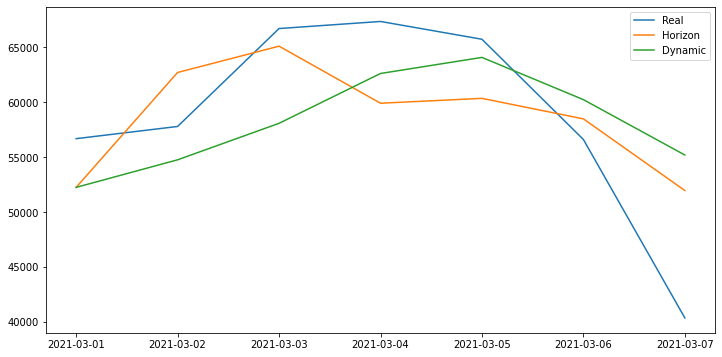

In [45]:
# Pintamos la serie

plt.figure(figsize=(12, 6))
plt.plot(target_test[0:7], label='Real')
plt.plot(pred['cases'], label='Horizon')
plt.plot(rfr_dynamic_forecast['cases'], label='Dynamic')
plt.legend()

In [46]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test[0:7], pred['cases']))
print('Error mae: ', mean_absolute_error(target_test[0:7], pred['cases']))
print('Error mse: ', mean_squared_error(target_test[0:7], rfr_dynamic_forecast['cases']))
print('Error mae: ', mean_absolute_error(target_test[0:7], rfr_dynamic_forecast['cases']))

Error mse:  38501869.0082143
Error mae:  5328.775714285715
Error mse:  51792555.88368571
Error mae:  5856.76


Vemos que el modelo de horizontes es mejor para predecir la primera semana. Vamos a ver si se cumple para las siguientes.

In [47]:
# Funcion para comparar el modelo de horizontes y el dinamico
def forecast_comparison(X_hor, X_dyn, hor_models, dyn_model, first_date, curr_date, pred_col, target_test):
    d = (curr_date - first_date).days
    n = len(X_hor)
    
    # Preparamos los datos para la predicion de horizontes
    X = []
    for i in range(n):
        X.append(X_hor[i][d:d + 1])
    
    # Hacemos las predicciones
    rfr_horizons_forecast = make_horizon_predictions(X = X, models = hor_models, curr_date = curr_date, pred_col = pred_col)
    rfr_dynamic_forecast = make_predictions(dyn_model, X_dyn[d:d + 1], curr_date, curr_date + pd.DateOffset(n - 1), pred_col)
    
    # Calculamos las metricas
    hor_mse = mean_squared_error(target_test[d:d + n], pred['cases'])
    hor_mae = mean_absolute_error(target_test[d:d + n], pred['cases'])
    dyn_mse = mean_squared_error(target_test[d:d + n], rfr_dynamic_forecast['cases'])
    dyn_mae = mean_absolute_error(target_test[d:d + n], rfr_dynamic_forecast['cases'])
    
    return hor_mse, hor_mae, dyn_mse, dyn_mae

In [48]:
forecast_comparison(X_test_horizons, X_test_1, rfr_hor, rfr, pd.to_datetime('2021-03-01'), pd.to_datetime('2021-03-01'), ['cases', 'deaths'], target_test)

(38501869.0082143, 5328.775714285715, 51792555.88368571, 5856.76)

In [49]:
# Funcion para calcular las metricas de prediccion semanal para cada dia de testeo
def create_forecast_metrics(X_hor, X_dyn, hor_models, dyn_model, first_date, end_date, pred_col, target_test, cols = ['horizon_mse', 'horizon_mae', 'dynamic_mse', 'dynamic_mae']):
    forecast_metrics = pd.DataFrame()
    curr_date = first_date

    while curr_date <= end_date - pd.DateOffset(7):
        new_metrics = forecast_comparison(X_test_horizons, X_test_1, rfr_hor, rfr, pd.to_datetime('2021-03-01'), curr_date, ['cases', 'deaths'], target_test)
        forecast_metrics = forecast_metrics.append(pd.DataFrame([new_metrics], columns = cols, index = [curr_date]))
        curr_date += pd.DateOffset(1)

    return forecast_metrics

In [50]:
forecast_metrics = create_forecast_metrics(X_test_horizons, X_test_1, rfr_hor, rfr, pd.to_datetime('2021-03-01'), pd.to_datetime('2021-04-06'), ['cases', 'deaths'], target_test)

In [51]:
forecast_metrics.T

2021-03-01    2021-03-02    2021-03-03    2021-03-04  \
horizon_mse  3.850187e+07  3.711100e+08  3.230617e+08  3.142481e+08   
horizon_mae  5.328776e+03  1.230008e+04  1.243236e+04  1.336643e+04   
dynamic_mse  5.179256e+07  2.894518e+08  3.022568e+08  3.026071e+08   
dynamic_mae  5.856760e+03  1.035109e+04  1.033864e+04  1.067510e+04   

               2021-03-05    2021-03-06    2021-03-07    2021-03-08  \
horizon_mse  3.513628e+08  2.604142e+08  2.220369e+08  3.607408e+08   
horizon_mae  1.403442e+04  1.178251e+04  9.803621e+03  1.271714e+04   
dynamic_mse  3.013183e+08  3.007997e+08  3.107418e+08  3.782550e+08   
dynamic_mae  1.015358e+04  1.017343e+04  1.011185e+04  1.165119e+04   

               2021-03-09    2021-03-10    2021-03-11    2021-03-12  \
horizon_mse  8.757263e+07  9.285224e+07  1.288693e+08  1.666526e+08   
horizon_mae  7.255887e+03  6.221056e+03  9.060047e+03  1.000716e+04   
dynamic_mse  3.044583e+08  4.120614e+07  4.258188e+07  4.540609e+07   
dynamic_mae  1.604485e+04  4.724071e+03  4.949201e+03  5.323699e+03   

               2021-03-13    2021-03-14    2021-03-15    2021-03-16  \
horizon_mse  1.130239e+08  5.136211e+07  6.572392e+07  9.506448e+07   
horizon_mae  7.580661e+03  5.245187e+03  6.014713e+03  6.226173e+03   
dynamic_mse  5.470647e+07  6.896566e+07  7.729656e+07  4.284443e+07   
dynamic_mae  4.940089e+03  7.874226e+03  8.586596e+03  5.768269e+03   

               2021-03-17    2021-03-18    2021-03-19    2021-03-20  \
horizon_mse  1.166655e+08  2.371890e+08  2.703066e+08  2.794690e+08   
horizon_mae  7.589627e+03  1.173477e+04  1.357288e+04  1.396083e+04   
dynamic_mse  5.463699e+07  1.508763e+08  2.029942e+08  2.906384e+08   
dynamic_mae  7.012750e+03  7.834870e+03  1.038166e+04  1.371746e+04   

               2021-03-21    2021-03-22    2021-03-23    2021-03-24  \
horizon_mse  1.826487e+08  8.730573e+07  1.561433e+08  1.990497e+08   
horizon_mae  1.262445e+04  8.031456e+03  1.051318e+04  1.179934e+04   
dynamic_mse  3.106902e+08  3.290498e+08  3.806626e+08  2.457432e+08   
dynamic_mae  1.530921e+04  1.614606e+04  1.745789e+04  1.435967e+04   

               2021-03-25    2021-03-26    2021-03-27    2021-03-28  \
horizon_mse  1.536904e+08  2.546484e+08  1.627312e+08  1.060840e+08   
horizon_mae  1.130354e+04  1.322938e+04  1.114444e+04  9.482439e+03   
dynamic_mse  1.251236e+08  2.117960e+08  1.638349e+08  1.683960e+08   
dynamic_mae  8.912746e+03  1.286590e+04  1.111236e+04  1.108820e+04   

               2021-03-29    2021-03-30  
horizon_mse  1.426226e+08  2.083684e+08  
horizon_mae  9.888884e+03  1.240175e+04  
dynamic_mse  2.037096e+08  1.134856e+08  
dynamic_mae  1.339268e+04  7.662966e+03

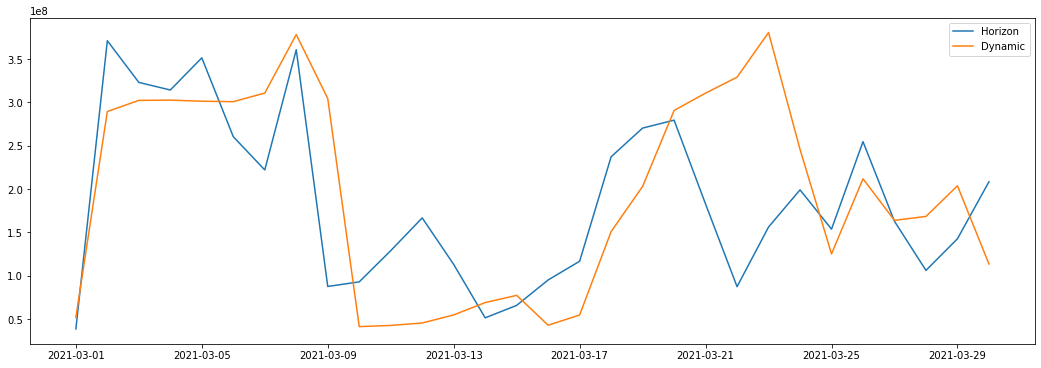

In [52]:
# Pintamos la serie de mse

plt.figure(figsize=(18, 6))
plt.plot(forecast_metrics['horizon_mse'], label='Horizon')
plt.plot(forecast_metrics['dynamic_mse'], label='Dynamic')
plt.legend()

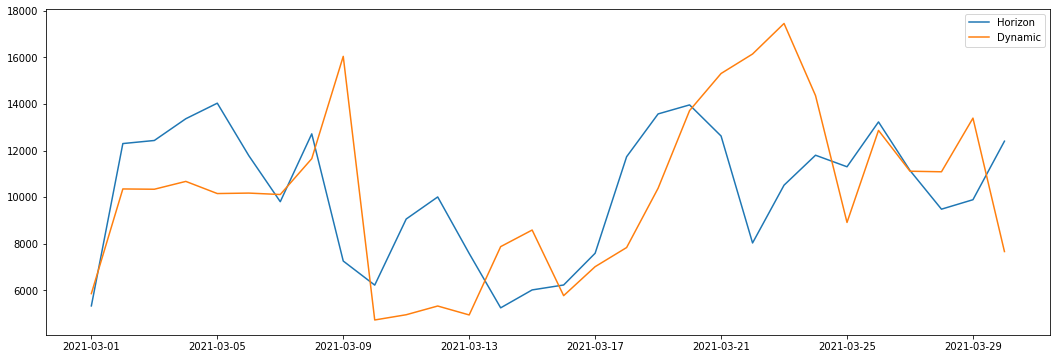

In [53]:
# Pintamos la serie de mae

plt.figure(figsize=(18, 6))
plt.plot(forecast_metrics['horizon_mae'], label='Horizon')
plt.plot(forecast_metrics['dynamic_mae'], label='Dynamic')
plt.legend()

In [54]:
forecast_metrics.mean()

horizon_mse    1.866507e+08
horizon_mae    1.022177e+04
dynamic_mse    1.955442e+08
dynamic_mae    1.015923e+04
dtype: float64

## Conclusiones

El modelo de horizontes tiene menos error quadrado de media respecto al resto para predecir semanas enteras, si solo queremos predecir el dia siguiente hemos visto que el mejor modelo es el de random forest usando los datos de casos y de muertos.

Para generar un modelo final seria interesante hacer una combinación de ambos, tanto el de horizontes como el dinamico para tener un modelo mas robusto, ya que en algunos puntos el modelo dynamico hace mejores predicciones que el de horizontes.